In [2]:
# 04_Model_Comparison - Kickstarter Dataset
# ====================================================

import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, RocCurveDisplay

In [3]:
# Step 1. Load preprocessor & data
# ----------------------------------------------------
preprocessor = joblib.load("../models/preprocessor.pkl")
X_train, X_test, y_train, y_test = joblib.load("../models/split_data.pkl")

print("Data loaded ✅")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Data loaded ✅
Train shape: (177880, 6) Test shape: (44470, 6)


In [4]:
# Step 2. Define Models (default params)
# ----------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        use_label_encoder=False
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        n_jobs=-1
    )
}

results = {}

In [5]:
# ----------------------------------------------------
# Step 3. Train & Evaluate Models
# ----------------------------------------------------
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    print("Accuracy:", acc)
    print("AUC:", auc)
    print(classification_report(y_test, y_pred))
    
    results[name] = {"acc": acc, "auc": auc, "model": pipe}


=== Logistic Regression ===
Accuracy: 0.6763211153586688
AUC: 0.7388999981470661
              precision    recall  f1-score   support

           0       0.52      0.66      0.58     15278
           1       0.79      0.68      0.73     29192

    accuracy                           0.68     44470
   macro avg       0.66      0.67      0.66     44470
weighted avg       0.70      0.68      0.68     44470


=== Random Forest ===
Accuracy: 0.7733528221272769
AUC: 0.827550237875112
              precision    recall  f1-score   support

           0       0.72      0.55      0.62     15278
           1       0.79      0.89      0.84     29192

    accuracy                           0.77     44470
   macro avg       0.76      0.72      0.73     44470
weighted avg       0.77      0.77      0.76     44470


=== XGBoost ===


c:\Mini_H\kickstarter\kick_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7397571396447042
AUC: 0.7764844236860429
              precision    recall  f1-score   support

           0       0.68      0.45      0.54     15278
           1       0.76      0.89      0.82     29192

    accuracy                           0.74     44470
   macro avg       0.72      0.67      0.68     44470
weighted avg       0.73      0.74      0.72     44470


=== LightGBM ===
[LightGBM] [Info] Number of positive: 116768, number of negative: 61112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 177880, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.656443 -> initscore=0.647481
[LightGBM] [Info] Start training from score 0.647481


c:\Mini_H\kickstarter\kick_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Mini_H\kickstarter\kick_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.7371936136721385
AUC: 0.7708516612513041
              precision    recall  f1-score   support

           0       0.68      0.44      0.53     15278
           1       0.75      0.89      0.82     29192

    accuracy                           0.74     44470
   macro avg       0.72      0.67      0.68     44470
weighted avg       0.73      0.74      0.72     44470



c:\Mini_H\kickstarter\kick_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


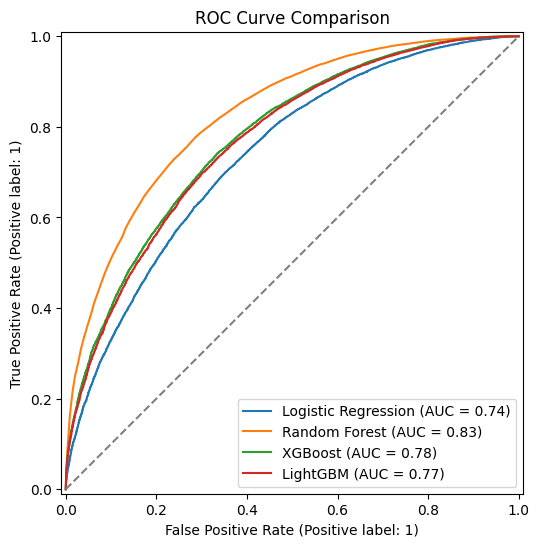

In [6]:
# Step 4. ROC Curve Comparison
# ----------------------------------------------------
plt.figure(figsize=(8,6))

for name, res in results.items():
    y_proba = res["model"].predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=plt.gca())

plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve Comparison")
plt.show()

In [7]:
# Step 5. Summary Table
# ----------------------------------------------------
print("\n=== Model Comparison Summary ===")
for name, res in results.items():
    print(f"{name:20s} | Accuracy: {res['acc']:.3f} | AUC: {res['auc']:.3f}")


=== Model Comparison Summary ===
Logistic Regression  | Accuracy: 0.676 | AUC: 0.739
Random Forest        | Accuracy: 0.773 | AUC: 0.828
XGBoost              | Accuracy: 0.740 | AUC: 0.776
LightGBM             | Accuracy: 0.737 | AUC: 0.771


In [8]:
import joblib

# Simpan preprocessor
joblib.dump(preprocessor, "../models/preprocessor.pkl")

# Simpan model terbaik (misalnya Random Forest)
best_model = results["Random Forest"]["model"].named_steps["model"]  # ambil model dari pipeline
joblib.dump(best_model, "../models/best_model.pkl")

print("✅ Preprocessor & model sudah disimpan!")

✅ Preprocessor & model sudah disimpan!
